# Video Analytics Character Detection

# Helper Functions

In [56]:
import cv2
import json
import requests
import urllib3

urllib3.disable_warnings()
s = requests.Session()
dora_url = "https://129.40.124.167/powerai-vision/api/dlapis/e7de9042-fc59-41af-94c7-67c21cbe3920"
spongebob_url = "https://129.40.124.167/powerai-vision/api/dlapis/1eb747e7-af21-4b6d-8ebd-fb5e6e60be00"
darthvader_url = "https://129.40.124.167/powerai-vision/api/dlapis/11fa820e-65c6-4af6-87c8-4549970d5d08"
woody_url = "https://129.40.124.167/powerai-vision/api/dlapis/093f56e6-28c5-4754-9ca4-d4687fc581e6"
    
WHITE = (255, 255, 255)
YELLOW = (66, 244, 238)
GREEN = (80, 220, 60)
LIGHT_CYAN = (255, 255, 224)
DARK_BLUE = (139, 0, 0)
GRAY = (128, 128, 128)

def detect_objects(filename, model_url):

    with open(filename, 'rb') as f:
        # WARNING! verify=False is here to allow an untrusted cert!
        r = s.post(model_url,
                   files={'files': (filename, f)},
                   verify=False)

    return r.status_code, json.loads(r.text)

def label_object(color, textcolor, fontface, image, label, textsize, thickness, xmax, xmid, xmin, ymax, ymid, ymin):
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, thickness)
    pos = (xmid - textsize[0]//2, ymid + textsize[1]//2)
    cv2.putText(image, label, pos, fontface, 1, textcolor, thickness, cv2.LINE_AA)

def score_frames(result, filename):
    img = cv2.imread(filename)
    for obj in result:
            ymin = obj.get("ymin", "")
            ymax = obj.get("ymax", "")
            ymid = int(round((ymin+ymax)/2))
            xmin = obj.get("xmin", "")
            xmax = obj.get("xmax", "")
            xmid = int(round((xmin+xmax)/2))
            label = obj.get("label", "")
            fontface = cv2.FONT_HERSHEY_SIMPLEX
            fontscale = 1
            thickness = 1
            textsize, _baseline = cv2.getTextSize(
             label, fontface, fontscale, thickness)
            label_object(GREEN, YELLOW, fontface, img, label, textsize, 4, xmax, xmid, xmin, ymax, ymid, ymin)

    cv2.imwrite("output/output-" + filename.split('/')[1], img)
    frame = cv2.imread("output/output-" + filename.split('/')[1])
    clear_output(wait=True)
    rows, columns, _channels = frame.shape
    frame = cv2.resize(frame, (int(columns/2), int(rows/2)))  # shrink it
    _ret, jpg = cv2.imencode('.jpg', frame)
    display(Image(data=jpg))            


# Split Video Into Sample Frames

In [87]:
import json
import glob
import math
import os
import shutil

import cv2
from IPython.display import clear_output, Image, display
import requests

FRAMES_DIR = "frames"  # Output dir to hold/cache the original frames
OUTPUT_DIR = "output"  # Output dir to hold the annotated frames
SAMPLING = 50  # Classify every n frames (use tracking in between)

#*********** change video file here **********
input_video = "spongebob/test/SpongebobReal1.mp4"
print("Sampling every %sth frame" % SAMPLING)

if os.path.isfile(input_video):
    video_capture = cv2.VideoCapture(input_video)
else:
    raise Exception("File %s doesn't exist!" % input_video)

total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
stop_frame = total_frames-(total_frames%SAMPLING)-SAMPLING
if (total_frames %SAMPLING == 0):
    stop_frame = stop_frame-SAMPLING
print("Frame count estimate is %d" % total_frames)
print("Stop at frame number",stop_frame )

files = glob.glob(FRAMES_DIR+"/*.jpg")
print("DELETING "+FRAMES_DIR+"/*.jpg")
for f in files:
    os.remove(f)
files = glob.glob(FRAMES_DIR+"/*.json")
print("DELETING "+FRAMES_DIR+"/*.json")
for f in files:
    os.remove(f)
num = 0
#while video_capture.get(cv2.CAP_PROP_POS_FRAMES) < video_capture.get(cv2.CAP_PROP_FRAME_COUNT):
while num < stop_frame:
    success, image = video_capture.read()
    if success:
        num = int(video_capture.get(cv2.CAP_PROP_POS_FRAMES))
        print("Reading frame {num} of {total_frames}".format(
            num=num, total_frames=stop_frame), end="\r")
        if video_capture.get(cv2.CAP_PROP_POS_FRAMES) % SAMPLING == 0:  # Sample every Nth
            cv2.imwrite('{frames_dir}/frame_{num:05d}.jpg'.format(
            frames_dir=FRAMES_DIR, num=num), image)
    else:
        # TODO: If this happens, we need to add retry code
        raise Exception('Error writing frame_{num:05d}.jpg'.format(
            num=int(video_capture.get(cv2.CAP_PROP_POS_FRAMES))))

print("\nWrote {num} frames".format(num=num/SAMPLING), " to ",FRAMES_DIR, )

FRAME_FPS = int(video_capture.get(cv2.CAP_PROP_FPS))
FRAME_WIDTH = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
FRAME_HEIGHT = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
ROI_YMAX = int(round(FRAME_HEIGHT * 0.75))  # Bottom quarter = finish line

print("Frame Dimensions: %sx%s" % (FRAME_WIDTH, FRAME_HEIGHT))

Sampling every 50th frame
Frame count estimate is 3132
Stop at frame number 3050
DELETING frames/*.jpg
DELETING frames/*.json
Reading frame 3050 of 3050
Wrote 61.0 frames  to  frames
Frame Dimensions: 1280x720


# Cache All Results

In [88]:
# Serialize requests, storing them in a "tracking_results" dict

try:
    with open('frames/frame-data-newmodel.json') as existing_results:
        cache_results = json.load(existing_results)
except Exception:
    # Any fail to read existing results means we start over
    cache_results = {}


i = 0
cache_used = 0
sampled = 0
for filename in sorted(glob.glob('frames/frame_*.jpg')):
    i += 1

    existing_result = cache_results.get(filename)
    if existing_result and existing_result['result'] == 'success':
        cache_used += 1
    else:
        #******* change character URL ******************
        rc, results = detect_objects(filename, spongebob_url)
        if rc != 200 or results['result'] != 'success':
            print("ERROR rc=%d for %s" % (rc, filename))
            print("ERROR result=%s" % results)
        else:
            # Save frequently to cache partial results
            cache_results[filename] = results
            with open('frames/frame-data-newmodel.json', 'w') as fp:
                json.dump(cache_results, fp)

    print("Processed file {num} (used cache {cache_used} times)".format(
        num=i, cache_used=cache_used), end="\r")

# Finally, write all our results
with open('frames/frame-data-newmodel.json', 'w') as fp:
    json.dump(cache_results, fp)

print("\nDone")

Processed file 61 (used cache 0 times)
Done


# Demo

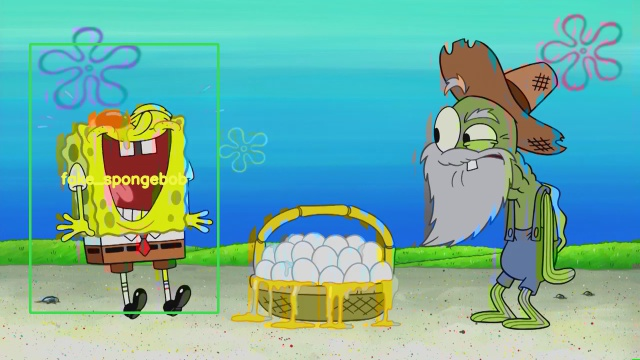

Processed file number 57
Processed file number 58
Processed file number 59
Processed file number 60
Processed file number 61
Done


In [89]:
counter = 0
with open('frames/frame-data-newmodel.json') as existing_results:
    sample_frames = json.load(existing_results)

files = glob.glob("output/*.jpg")
print("DELETING "+"output/*.jpg")
for f in files:
    os.remove(f)
    
for filename in sorted(glob.glob('frames/frame_*.jpg')):
    counter += 1
        #img = cv2.imread(filename)
    if filename in sample_frames and 'classified' in sample_frames[filename]:
#            print(sample_frames[filename]['classified'])
        objects = sample_frames[filename]['classified'] 
        for i in objects:
#                label = i.get("label", "")
#                confidence = i.get("confidence", "")
#                print(label, "w/ prediction score:",confidence)
            boxes= score_frames(objects, filename)
        print("Processed file number", counter)
print("Done")

# Create a video from the annotated frames

In [39]:
import os

command = "ffmpeg -pattern_type glob -i 'output/output*.jpg' -vcodec mpeg4 -r 30 -pix_fmt yuv422p -y out.mp4"
os.system(command)

0

In [40]:
import io
import base64
from IPython.display import HTML

video = io.open('out.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

# Update File Metadata

In [90]:
import csv

with open('frames/frame-data-newmodel.json') as existing_results:
    sample_frames = json.load(existing_results)

with open('metadata.csv', 'w') as metadata:
    writer = csv.writer(metadata)
    
    for filename in sorted(glob.glob('frames/frame_*.jpg')):
        
        labels = ''
        if filename in sample_frames and 'classified' in sample_frames[filename]:
            objects = sample_frames[filename]['classified'] 
            for i in objects:
                confidence = i.get("confidence", "")
                label = i.get("label", "") + " " + "(" + str(round((confidence*100),2)) + "%)"
                if (labels == ''):
                    labels = label
                else:
                    labels = labels + " " + label
            new_row = [filename, labels]
            writer.writerow(new_row)
            command = 'mmchattr --set-attr user.labels=' + '"' + labels + '"' + " " + filename
            #os.system(command)
            print("found " + labels + " in "+ filename)
            #print(command)
print("Done")

found  in frames/frame_00050.jpg
found fake_spongebob (77.98%) in frames/frame_00100.jpg
found fake_spongebob (98.27%) in frames/frame_00150.jpg
found fake_spongebob (96.62%) in frames/frame_00200.jpg
found fake_spongebob (90.67%) in frames/frame_00250.jpg
found fake_spongebob (68.69%) in frames/frame_00300.jpg
found fake_spongebob (99.16%) in frames/frame_00350.jpg
found  in frames/frame_00400.jpg
found  in frames/frame_00450.jpg
found  in frames/frame_00500.jpg
found fake_spongebob (99.33%) in frames/frame_00550.jpg
found fake_spongebob (98.83%) in frames/frame_00600.jpg
found  in frames/frame_00650.jpg
found  in frames/frame_00700.jpg
found  in frames/frame_00750.jpg
found  in frames/frame_00800.jpg
found  in frames/frame_00850.jpg
found  in frames/frame_00900.jpg
found  in frames/frame_00950.jpg
found  in frames/frame_01000.jpg
found  in frames/frame_01050.jpg
found  in frames/frame_01100.jpg
found fake_spongebob (98.69%) in frames/frame_01150.jpg
found  in frames/frame_01200.jpg
f